## Description:

This file contains:
* target variable encoding
* fill na, drop unnecessary cols
* make train-val-test sets
* dummy model (all features)
* LGBM (all features)

In [1]:
'''Helper''' 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import time
import joblib

'''Pre-processing'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

'''Modeling'''
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     StratifiedKFold,
                                     StratifiedShuffleSplit)
from sklearn.metrics import classification_report, plot_confusion_matrix


'''GCS Utils'''
from gcs_utils import upload_serialized_file, upload_csv_file, download_file

import warnings
warnings.filterwarnings('ignore')

'''BQ'''
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

SEED=42

In [2]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data'
file_name = 'training_data_11192021.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name) 

### Training Data - Features

**Numerical Features**
1. User metrics
    * unique pageviews per session (avg, median)
    * timeOnPage per session (avg, median) <br><br>
2. Session metrics
    * bounceRate  <br><br>
3. Content metrics
    * contentViewsRate (contentViews / pageViews) <br>

**Categorical Features**
1. Content categories 
    * Sum pvs - Tier1, Tier2, Primary Channel, Primary Section
    * Avg. top - Tier1 <br><br>
2. Timestamp features: 

    * Weekday vs Weekend 
        * Sum pvs & avg. top
    * Business Hours vs Non-Business Hours *(Differentiated by US and other countries)*
        * Sum pvs & avg. top
    * Day of week
        * avg. top
    * Day of month
        * avg. top
    * Hourly *(Differentiated by US and other countries)*
        * avg. top
    * Minute *(Differentiated by US and other countries)*
        * avg. top<br><br>
3. Device OS - Sum pvs
4. Referral source - Sum pvs
5. Countries - Sum pvs<br><br>

In [3]:
# read training data

df = pd.read_csv('training_data_11192021.csv', dtype={'ga_fullvisitorid': object})

print(df.shape)
print(df.isna().sum().unique())
df.dtypes.value_counts()

(507937, 627)
[0]


float64    623
object       2
int64        2
dtype: int64

In [4]:
df.head()

,ga_fullvisitorid,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_fbia,...,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top,subscription_status
0,10000145548747950113,1.0,1.0,454.0,454.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
1,10000150578546110250,1.0,1.0,14.5,12.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,non_subscriber
2,10000154461756058018,1.0,1.0,52.0,52.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
3,10000244735129548321,1.0,1.0,32.0,32.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber
4,10000256049462665870,1.0,1.0,15.0,15.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_subscriber


* Remove fvids which are not active subscribers as of 11/30/21

In [4]:
query_string = """
  WITH eligible_users AS ( 
      
       SELECT 
           DISTINCT 
               user_id_uid, 
               resource_id_rid, 
               start_date,
               status, 
               subscription_trial_end_date
              
    FROM
        `api-project-901373404215.piano.subscriber_details`
    WHERE 
        # Filter for the 'universal' subscriptions only
        resource_id_rid IN UNNEST(['RKPEVDB', 'R8W03AS'])
         # filter for active only
               AND status='active'
               AND total__refunded<1
               AND cast(dt_updated as date)=current_date('America/New_York')
        )
    
    # join user_id_uids with GA's pianoIDs and For each pianoID, get their fullvids. De-duplicate.
     SELECT 
         DISTINCT
            ga_pianoId,
            user_id_uid,
            ga_fullvisitorid,
            resource_id_rid,
            start_date,
            status, 
            subscription_trial_end_date
    FROM
        eligible_users
         INNER JOIN 
         `api-project-901373404215.DataMart.v_DataMart_updated` 
    ON 
        LOWER(ga_pianoId) = LOWER(user_id_uid)
"""
active_subs = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
) 

# get fvids list
active_subs_fvids = list(active_subs.ga_fullvisitorid.unique())

print("# active subs fvids in Database as of 11/30/21: ", 
      len(active_subs_fvids))

joblib.dump(active_subs_fvids, 
            "../data/active_subs_db_fvids_113021.joblib")

# active subs fvids in Database as of 11/30/21:  89328
# active fvids in training set:  78366 
 Perc:  0.8


In [5]:
active_subs_fvids = joblib.load("../data/active_subs_db_fvids_113021.joblib")

# 80% of our training set fvids are still active

print("# active fvids in training set: ", 
      df[(df.subscription_status=="subscriber") & (df.ga_fullvisitorid.isin(active_subs_fvids))].shape[0], 
      "\n Perc: ",
      round(df[df.ga_fullvisitorid.isin(active_subs_fvids)].shape[0]/97947, 2))

# active fvids in training set:  78366 
 Perc:  0.8


In [6]:
print("Before dropping inactive subs: \n", df.shape)

df.subscription_status.value_counts()

df = df.drop(df[(df.subscription_status=="subscriber") & (~df.ga_fullvisitorid.isin(active_subs_fvids))].index)

print("After dropping inactive subs: \n",df.shape, "\n")

df.subscription_status.value_counts()

Before dropping inactive subs: 
 (507937, 627)
After dropping inactive subs: 
 (488356, 627) 



non_subscriber    409990
subscriber         78366
Name: subscription_status, dtype: int64

* Fill NA
* Drop unnecesary cols
* Encode target variable

In [7]:
# fill any Nulls with 0

df.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in df.columns if 'other' in x] + ['ga_fullvisitorid']

df = df.drop(cols_to_drop, 
             axis=1)

# encode target - subs class 1, everyone else class 0

df['subscription_status'] = np.where(df['subscription_status']=='subscriber',
                                     1, 0)

In [8]:
df.subscription_status.value_counts(normalize=True)*100

0   84.0
1   16.0
Name: subscription_status, dtype: float64

**Train - test split**
* Why train-test split before feature selection - to avoid information leakage
* In sklearn's train_test_split by default shuffle=TRUE

In [9]:
X = df.iloc[:, :-1]
y = df["subscription_status"]

# split the data in training and remaining dataset

X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y, 
                                                  train_size=0.7, 
                                                  stratify = y,
                                                  random_state = SEED 
                                                 )


# make test and val sets
X_val, X_test, y_val, y_test = train_test_split(X_rem,
                                                y_rem, 
                                                test_size=0.5,
                                                stratify = y_rem,
                                                random_state = SEED 
                                                )

* For all experiments, train and val sets will be used. 
* Test = left untouched

In [10]:
print("--- Train set ---", X_train.shape, y_train.shape, round(X_train.shape[0]/df.shape[0], 2))

print("--- Val set ---", X_val.shape, y_val.shape, round(X_val.shape[0]/df.shape[0], 2))

print("--- Test set ---", X_test.shape, y_test.shape, round(X_test.shape[0]/df.shape[0], 2))

--- Train set --- (341849, 618) (341849,) 0.7
--- Val set --- (73253, 618) (73253,) 0.15
--- Test set --- (73254, 618) (73254,) 0.15


In [23]:
print("Distribution in train set:")
print(y_train.value_counts(), "\n")

print("Distribution in val set:")
print(y_val.value_counts(), "\n")

print("Distribution in test set:")
print(y_test.value_counts(), "\n")

Distribution in train set:
0    286993
1     54856
Name: subscription_status, dtype: int64 

Distribution in val set:
0    61498
1    11755
Name: subscription_status, dtype: int64 

Distribution in test set:
0    61499
1    11755
Name: subscription_status, dtype: int64 



* Save files<br>

In [11]:
train_set = X_train.join(y_train)
val_set = X_val.join(y_val)
test_set = X_test.join(y_test)

In [12]:
train_set.to_csv("./chk_files/chk_train_set_11302021.csv", index=False)
val_set.to_csv("./chk_files/chk_val_set_11302021.csv", index=False)
test_set.to_csv("./chk_files/chk_test_set_11302021.csv", index=False)

* Cross-val splitting

    * **StratifiedKFold w/ shuffle=True**  - shuffles and splits once. So, test folds formed without replacement (no overlap)

    * **StratifiedShuffleSplit**  - shuffles each time before splitting. So, test folds formed with replacement (with overlap)

[Ref](https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn)

In [13]:
scoring='f1_weighted'

skf = StratifiedKFold(n_splits = 10, 
                      shuffle=True,
                      random_state = SEED)

sss = StratifiedShuffleSplit(n_splits = 5, 
                             test_size = 0.2, 
                             random_state = SEED) 

* **Dummy classifier** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit
    
    
* Pred Strategies
    * **stratified** generates random predictions by respecting the training set class distribution.
    * **most_frequent** always predicts the most frequent label in the training set.
    * **uniform** generates predictions uniformly at random.

In [14]:
dummy_strategies = ['stratified', 'uniform', 'most_frequent']

for item in dummy_strategies:
    
    scaler = RobustScaler()

    dummy = DummyClassifier(strategy=item,random_state = SEED)

    dummy = Pipeline(
        steps=[
            ('scaler', scaler),
            ('model', dummy)
        ]
    )

    dummy_score = cross_val_score(
        dummy,
        X_train,
        y_train,
        cv=skf, # using StratifiedKFold w/ shuffle=True
        n_jobs=-1,
        scoring=scoring
    )
    
    print("Strategy: ", item)
    print(dummy_score)
    print("Dummy average score is", round(np.mean(dummy_score), 2), "\n") 
    

print("Classification report for Strategy: most_frequent")

dummy_preds = [0] * 73253
print(classification_report(y_val, 
                            dummy_preds, 
                            target_names = ['Non-subscriber', 'subscriber'])) 

Strategy:  stratified
[0.73170536 0.73047438 0.72947787 0.72930202 0.73270186 0.72953649
 0.73121699 0.73180315 0.73174453 0.73279181]
Dummy average score is 0.73 

Strategy:  uniform
[0.56753483 0.5619369  0.56437963 0.56336183 0.56626257 0.56473586
 0.56513021 0.56243311 0.56451954 0.56448007]
Dummy average score is 0.56 

Strategy:  most_frequent
[0.76628051 0.76628051 0.76628051 0.76628051 0.76628051 0.76628051
 0.76632173 0.76632173 0.76632173 0.76631511]
Dummy average score is 0.77 

Classification report for Strategy: most_frequent
                precision    recall  f1-score   support

Non-subscriber       0.84      1.00      0.91     61498
    subscriber       0.00      0.00      0.00     11755

      accuracy                           0.84     73253
     macro avg       0.42      0.50      0.46     73253
  weighted avg       0.70      0.84      0.77     73253



* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy - StratifiedShuffleSplit 

In [15]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=sss,
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99033138 0.99048457 0.99037276 0.99089695 0.99023221]
LGBM base score is 0.9904635727658405


* **LGBM** 
    * All features
    * Scaled feature values
    * Imbalanced dataset
    * cross-val strategy -  StratifiedKFold w/ shuffle=True

In [16]:
scaler = RobustScaler()

model = lgb.LGBMClassifier(random_state=SEED, 
                           is_unbalance=True) # is_unbalance because train data is imbalanced

model = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', model)
    ]
)

lgbm_base_score = cross_val_score(
    model,
    X_train,
    y_train,
    cv=skf, # using StratifiedKFold w/ shuffle=True
    n_jobs=-1,
    scoring=scoring
)

print(lgbm_base_score)
print("LGBM base score is", np.mean(lgbm_base_score))

[0.99011944 0.99004569 0.99025397 0.99063385 0.9900032  0.99089856
 0.99007541 0.99149428 0.9902042  0.99145355]
LGBM base score is 0.9905182168532954


* Pred on val set
    * captures the effect of removing inactive subs
    * f1 for subs decreased 1% (no significant drop)
    * Overall Weighted-f1 = same

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61498
    subscriber       0.95      0.98      0.97     11755

      accuracy                           0.99     73253
     macro avg       0.98      0.99      0.98     73253
  weighted avg       0.99      0.99      0.99     73253



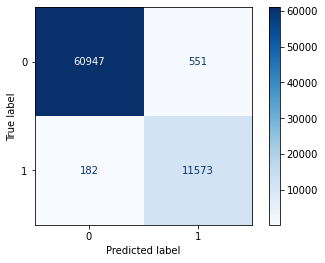

In [17]:
# using skf pipe, pred on val set

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, 
                            y_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_val, 
                      y_true=y_val, 
                      cmap='Blues'
                     )

* Pred on test set

                precision    recall  f1-score   support

Non-subscriber       1.00      0.99      0.99     61499
    subscriber       0.96      0.99      0.97     11755

      accuracy                           0.99     73254
     macro avg       0.98      0.99      0.98     73254
  weighted avg       0.99      0.99      0.99     73254



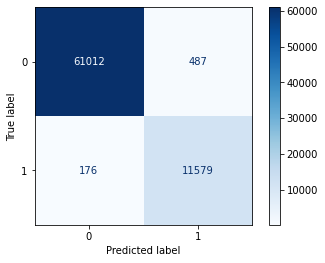

In [18]:
# using skf pipe, pred on test set

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, 
                            y_test_pred, 
                            target_names = ['Non-subscriber', 'subscriber']))

plot_confusion_matrix(estimator=model, 
                      X=X_test, 
                      y_true=y_test, 
                      cmap='Blues'
                     )